In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import uuid
from ibl_pipeline import subject, acquisition, histology
from ibl_pipeline.analyses import behavior
from oneibl import one
from export_funs import trialinfo_to_df

one = one.ONE()
%matplotlib inline

Connecting gercek@datajoint.internationalbrainlab.org:3306
Connected to https://alyx.internationalbrainlab.org as berk.gercek
Connected to https://alyx.internationalbrainlab.org as berk.gercek
Connected to https://alyx.internationalbrainlab.org as berk.gercek
Connected to https://alyx.internationalbrainlab.org as berk.gercek


In [2]:
unitlabels = acquisition.Session * histology.ClusterBrainRegion *\
    subject.Subject * behavior.SessionTrainingStatus &\
    {'good_enough_for_brainwide_map': 1, 'insertion_data_source': 'Ephys aligned histology track'}
bwm_sess = unitlabels & {'insertion_data_source': 'Ephys aligned histology track',
                        'good_enough_for_brainwide_map': 1,}
sessinfo = acquisition.Session * subject.Subject * histology.ProbeTrajectory
bwm_ids = [str(eid) for eid in bwm_sess.fetch('session_uuid')]
bwm_ids = list(set(bwm_ids))
bwm_sessinfo = {eid: (sessinfo & {'session_uuid': uuid.UUID(eid)}).fetch()[0] for eid in bwm_ids}

In [3]:
from prior_funcs import fit_sess_psytrack
from ibl_pipeline.utils import psychofit as psy

psychtable = behavior.PsychResultsBlock * subject.Subject * acquisition.Session
xx = np.linspace(-100, 100, 100)
bwm_tdfs = {}
psytrfits = {}
psychfits = {}
for eid in bwm_ids:
    bwm_tdfs[eid] = trialinfo_to_df(eid, maxlen=2., wheel=False)
    psytrfits[eid] = fit_sess_psytrack(eid, maxlength=2., as_df=True)
    sess_psyfits = (psychtable & {'session_uuid': uuid.UUID(eid)}).fetch(format='frame').reset_index().set_index('prob_left_block')
    low = sess_psyfits.loc[20]
    mid = sess_psyfits.loc[50]
    high = sess_psyfits.loc[80]
    low_fit = psy.erf_psycho_2gammas(np.array([low.bias, low.threshold, low.lapse_low, low.lapse_high]), xx)
    mid_fit = psy.erf_psycho_2gammas(np.array([mid.bias, mid.threshold, mid.lapse_low, mid.lapse_high]), xx)
    high_fit = psy.erf_psycho_2gammas(np.array([high.bias, high.threshold, high.lapse_low, high.lapse_high]), xx)
    psychfits[eid] = {'low_fit': low_fit, 'mid_fit': mid_fit, 'high_fit': high_fit,
                      'data': sess_psyfits}
    
    

/home/berk/anaconda3/envs/priorloc/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



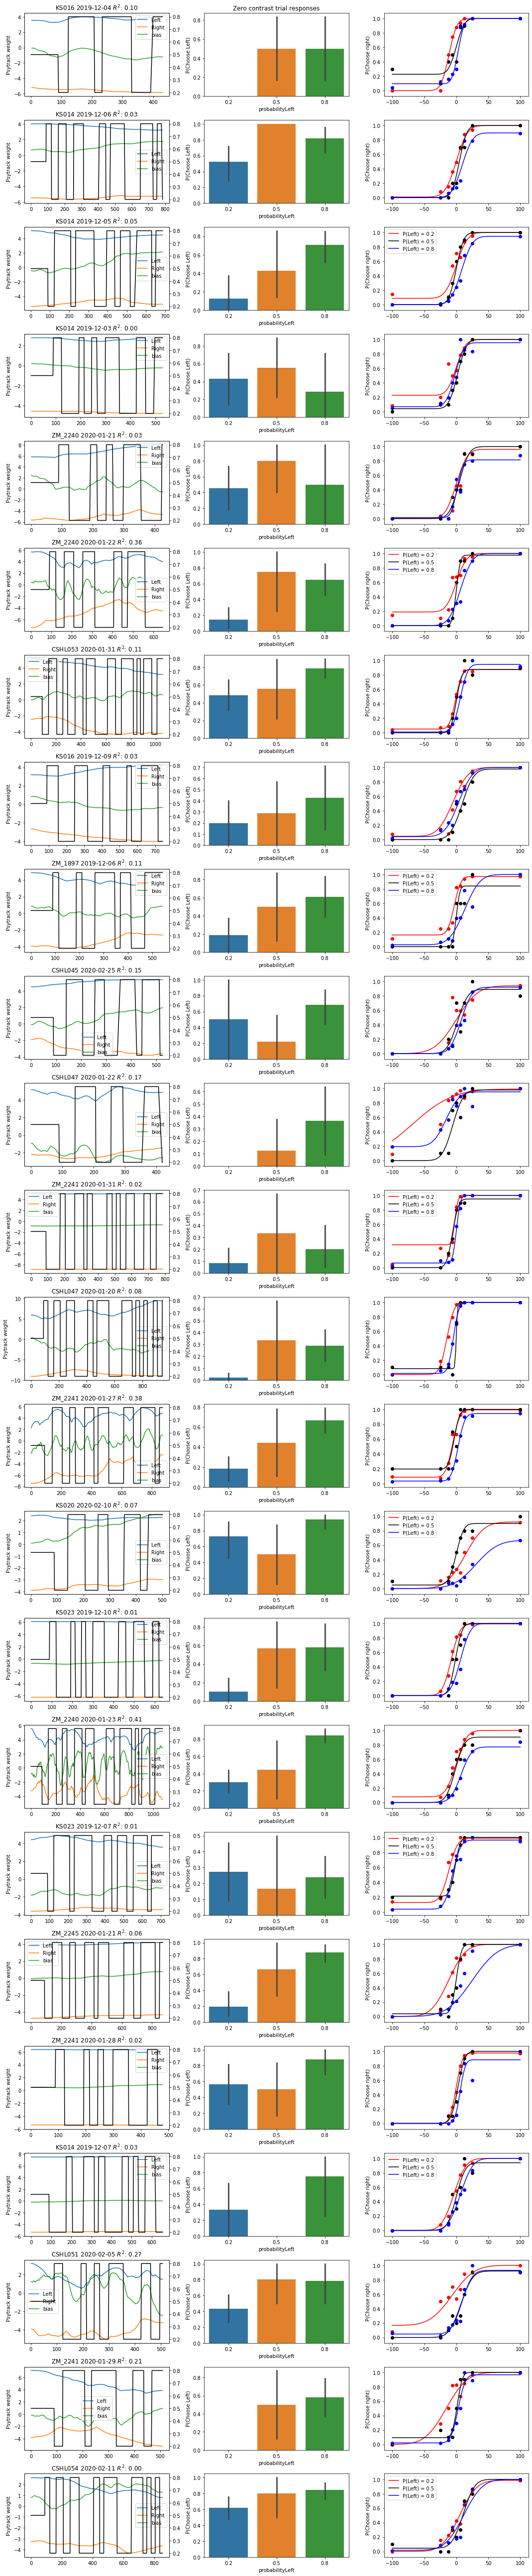

In [4]:
fig, axes = plt.subplots(len(bwm_ids), 3, figsize=(15, len(bwm_ids) * 3))
for i, eid in enumerate(bwm_ids):
    currdf = bwm_tdfs[eid]
    currpsy = psytrfits[eid][0]
    zcontr = currdf[(currdf.contrastLeft == 0) | (currdf.contrastRight == 0)]
    zcontr.loc[zcontr.choice == -1, 'choice'] = 0
    axes[i, 0].plot(currpsy.left, label='Left')
    axes[i, 0].plot(currpsy.right, label='Right')
    axes[i, 0].plot(currpsy.bias, label='bias')
    axes[i, 0].legend()
    axes[i, 0].set_ylabel('Psytrack weight')
    rsq = np.corrcoef(currpsy.bias - currpsy.bias.mean(), currdf.probabilityLeft.iloc[:-1])[0, 1]**2
    axes[i, 0].set_title(bwm_sessinfo[eid]['subject_nickname'] + ' ' + str(bwm_sessinfo[eid]['session_start_time'].date())
                         + r' $R^2$: ' + f'{rsq:0.2f}')
    tmpax = axes[i, 0].twinx()
    tmpax.plot(currdf.probabilityLeft, label='P(Left)', color='black')
    sns.barplot('probabilityLeft', 'choice', data=zcontr, ax=axes[i, 1])
    axes[i, 1].set_ylabel('P(Choose Left)')
    axes[i, 2].plot(xx, psychfits[eid]['low_fit'], label='P(Left) = 0.2', color='red')
    axes[i, 2].scatter(psychfits[eid]['data'].loc[20].signed_contrasts * 100,
                       psychfits[eid]['data'].loc[20].prob_choose_right, color='red')
    axes[i, 2].plot(xx, psychfits[eid]['mid_fit'], label='P(Left) = 0.5', color='black')
    axes[i, 2].scatter(psychfits[eid]['data'].loc[50].signed_contrasts * 100,
                       psychfits[eid]['data'].loc[50].prob_choose_right, color='black')
    axes[i, 2].plot(xx, psychfits[eid]['high_fit'], label='P(Left) = 0.8', color='blue')
    axes[i, 2].scatter(psychfits[eid]['data'].loc[80].signed_contrasts * 100,
                       psychfits[eid]['data'].loc[80].prob_choose_right, color='blue')
    axes[i, 2].set_ylabel('P(Choose right)')
    if (i + 1) % 3 == 0:
        axes[i, 2].legend()
    axes[0, 1].set_title('Zero contrast trial responses')
plt.tight_layout()
    

In [5]:
import uuid

missing_labels = {}
for eid in bwm_ids:
    sessprobes = np.unique((bwm_sess & {'session_uuid' : uuid.UUID(eid)}).fetch('probe_idx'))
    missing_labels[eid] = {}
    for probe_idx in sessprobes:
        missunits = []
        spk_clu = one.load(eid, dataset_types=['spikes.clusters'], offline=True)[probe_idx]
        clu_ids = np.unique(spk_clu)
        probetable = unitlabels & {'session_uuid': uuid.UUID(eid), 'probe_idx': probe_idx}
        regiondf = probetable.proj('cluster_id', 'acronym').fetch(format='frame').reset_index().set_index('cluster_id')
        for unit in clu_ids:
            if unit not in regiondf.index:
                missunits.append(unit)
        missing_labels[eid][probe_idx] = len(missunits) / clu_ids.shape[0]
        

In [6]:
from prior_funcs import fit_sess_psytrack
from ibl_pipeline.utils import psychofit as psy

psychtable = behavior.PsychResultsBlock * subject.Subject * acquisition.Session
xx = np.linspace(-100, 100, 100)
sess_psyfits = (psychtable & {'session_uuid': uuid.UUID(eid)}).fetch(format='frame').reset_index().set_index('prob_left_block')
lowparams = sess_psyfits.loc[20]


In [ ]:
sess_psyfits